> ### EEE4423: Deep Learning Lab

# LAB \#10: Image Style Transfer

<h4><div style="text-align: right"> Due date: May 13, 2022  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab10.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-11 02:38:02.487381




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>

This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [2]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

**Style and content image**

In [3]:
style_img_name = './dataset-dllab/lab10/style/mosaic.jpg'
content_img_name = './dataset-dllab/lab10/content/Tuebingen_Neckarfront.jpg'

In [4]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

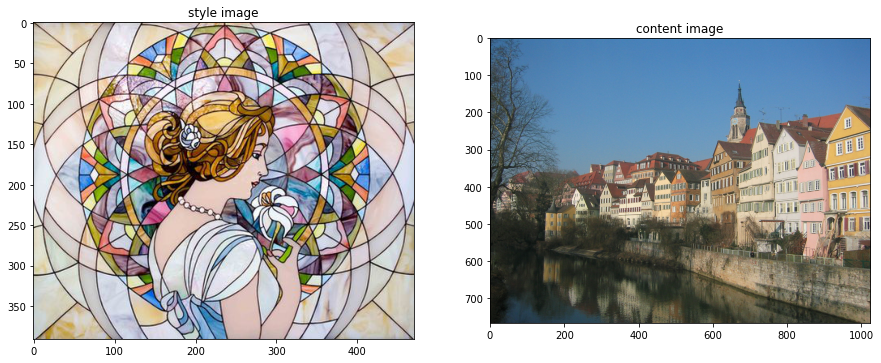

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h) #w*h=k (2차원 1차원으로 바꿔서)
    features_t = features.transpose(1, 2) #(b, wh, ch)
    gram = features.bmm(features_t) / (ch * h * w) #배치별로 행렬 곱 수행 (b,ch,ch)
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [7]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg = vgg.vgg19(pretrained=False)


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg.features._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [8]:
loss_net = LossNetwork().cuda()
checkpoint = torch.load('./pretrain/lab10/vgg19.pth')
loss_net.vgg.load_state_dict(checkpoint)
for param in loss_net.parameters():
    param.requires_grad = False

Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [9]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [10]:

img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [11]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [12]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [17]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 9.114269
Iteration: 100, loss: 6.454161
Iteration: 150, loss: 5.720257
Iteration: 200, loss: 5.370232
Iteration: 250, loss: 5.166455
Iteration: 300, loss: 5.031705
Iteration: 350, loss: 4.943039
Iteration: 400, loss: 4.874632
Iteration: 450, loss: 4.821828
Iteration: 500, loss: 4.780097


**Visualize result images**

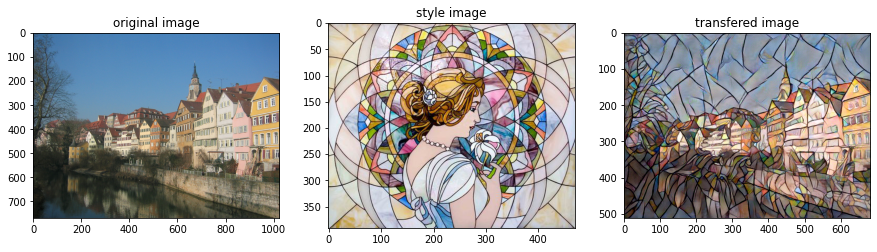

In [18]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>

$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [13]:
data_root = './dataset-dllab/lab10/train'
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net) [3 points]

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [14]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        #############
        #똑같은 조건으로 다섯번 반복하므로 blok을 만들어줬다.
        self.res_block=nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.InstanceNorm2d(128)
        )
        #res_block 전
        self.imagetransformnet1=nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=128, stride=2, kernel_size=3),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        #res_block 후
        self.imagetransformnet2=nn.Sequential(
            nn.Upsample(mode='nearest',scale_factor=2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Upsample(mode='nearest',scale_factor=2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d(4),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=9),
        
        )
        #############

    def forward(self, X):
        #############
        out=self.imagetransformnet1(X)
        for i in range(5):
            out=out+self.res_block(out)
        out=self.imagetransformnet2(out)
        
        return out
        #############


In [15]:
transformer = ImageTransformNet().cuda()

### 1.2 Find style and content representation layers in loss net [1 points]

In [16]:
'''
    vgg19_layer_names = {
    0: "conv1_1",
    1: "relu1_1",
    2: "conv1_2",
    3: "relu1_2",
    4: "pool1",
    5: "conv2_1",
    6: "relu2_1",
    7: "conv2_2",
    8: "relu2_2",
    9: "pool2",
    10: "conv3_1",
    11: "relu3_1",
    12: "conv3_2",
    13: "relu3_2",
    14: "conv3_3",
    15: "relu3_3",
    16: "conv3_4",
    17: "relu3_4",
    18: "pool3",
    19: "conv4_1",
    20: "relu4_1",
    21: "conv4_2",
    22: "relu4_2",
    23: "conv4_3",
    24: "relu4_3",
    25: "conv4_4",
    26: "relu4_4",
    27: "pool4",
    28: "conv5_1",
    29: "relu5_1",
    30: "conv5_2",
    31: "relu5_2",
    32: "conv5_3",
    33: "relu5_3",
    34: "conv5_4",
    35: "relu5_4",
    36: "pool5",
    37: "fc6",
    38: "relu6",
    39: "dropout6",
    40: "fc7",
    41: "relu7",
    42: "dropout7",
    43: "fc8"
}
'''
style_layer_name = {
   #############
    #논문의 조건은 vgg 16이지만, vgg 19를 사용한다. pooling 전 가장 마지막 relu를 사용한다. 
    '3':'relu1-2',
    '8':'relu2-2',
    '15':'relu3-3',
    '24':'relu4-3'
    #############
}

content_layer_name = {
    #############
    #그림에서는 relu3-3를 사용하라고 나와있지만, 논문의 조건은 relu2-2을 사용하라고 나와있다.
    '8':'relu2-2'
    #############
}

In [17]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

**Hyper parameters**

In [18]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

### 1.3 Train the image transformNet [4 points]

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [19]:
n_iter = 0
total_running_loss = 0.0
style_running_loss = 0.0
content_running_loss = 0.0
tv_running_loss = 0.0

class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            #############
            content_running_loss = 0
            style_running_loss = 0
            tv_running_loss = 0
            
            x = x.cuda()
            optimizer.zero_grad()
            
            #transformer 네트워크를 지난 결과
            y_hat = transformer(x)
            
            #content loss
            content_gt = [f for f in loss_net(x, content_layer_name).values()]#x를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
            content_layers = [f for f in loss_net(y_hat, content_layer_name).values()]#y_hat를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
            content_running_loss = criterion(content_layers[0], content_gt[0])#둘이 차이를 criterion으로 계산
            
            
            style_layers = [gram_matrix(f) for f in loss_net(y_hat, style_layer_name).values()]#style은 gram_matrix로 계산
            
            for i in range(len(style_layer_name)):#style layer가 여러개이므로    
                style_running_loss += criterion(style_layers[i], style_gt[i])
            
            
            tv_running_loss = torch.sum(torch.abs(y_hat[:, :, :, :-1] - y_hat[:, :, :, 1:])) + torch.sum(torch.abs(y_hat[:, :, :-1, :] - y_hat[:, :, 1:, :]))

            total_running_loss = alpha*content_running_loss + beta*style_running_loss + gamma*tv_running_loss
            total_running_loss.backward()
            optimizer.step()            
            n_iter += 1
            
            if n_iter%show_iter == (show_iter-1):
                print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss: %.2f tv loss: %.2f'%(n_iter+1, total_running_loss.item(),
                                                                                                             alpha*content_running_loss.item(), 
                                                                                                             beta*style_running_loss.item(), 
                                                                                                             gamma*tv_running_loss.item()))
                                                                                            
            #############
            
            if n_iter >= steps:
                raise Found

except Found:
    pass
    

Iteration: 50, total loss: 33.40, content loss: 13.36, style loss: 17.77 tv loss: 2.28
Iteration: 100, total loss: 24.37, content loss: 12.95, style loss: 8.85 tv loss: 2.57
Iteration: 150, total loss: 20.89, content loss: 10.88, style loss: 7.46 tv loss: 2.55
Iteration: 200, total loss: 20.72, content loss: 11.45, style loss: 6.69 tv loss: 2.59
Iteration: 250, total loss: 19.69, content loss: 11.63, style loss: 5.41 tv loss: 2.65
Iteration: 300, total loss: 18.36, content loss: 10.75, style loss: 4.97 tv loss: 2.64
Iteration: 350, total loss: 17.56, content loss: 9.99, style loss: 5.03 tv loss: 2.54
Iteration: 400, total loss: 17.18, content loss: 9.73, style loss: 4.81 tv loss: 2.64
Iteration: 450, total loss: 17.63, content loss: 10.71, style loss: 4.15 tv loss: 2.77
Iteration: 500, total loss: 16.21, content loss: 9.32, style loss: 4.23 tv loss: 2.66
Iteration: 550, total loss: 16.72, content loss: 10.00, style loss: 4.10 tv loss: 2.62
Iteration: 600, total loss: 16.49, content los

### 1.4 Discuss the result [2 points]
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

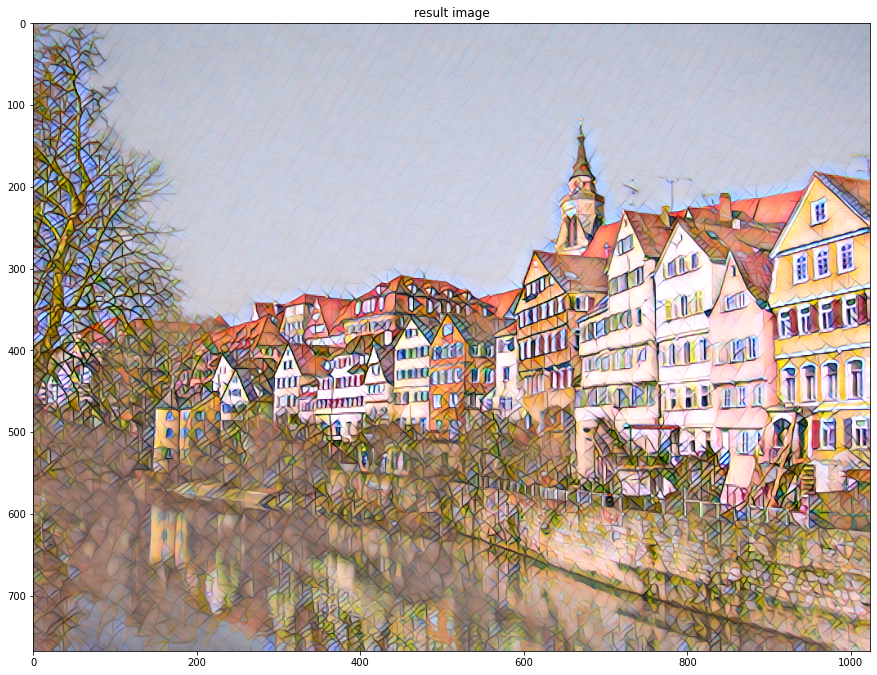

In [21]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
transformer.eval()
result_image=inverse_transform(transformer(test_transform(content_img).cuda().unsqueeze(0)).squeeze(0))

plt.figure(figsize=(15,15))
plt.title('result image')
plt.imshow(result_image)
plt.show()
#############


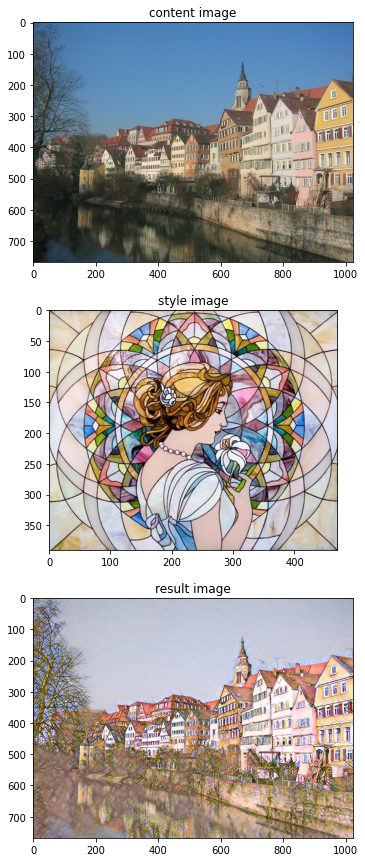

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title('content image')
plt.imshow(content_img)
plt.subplot(3,1,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(3,1,3)
plt.title('result image')
plt.imshow(result_image)
plt.show()

adjust hyperparameters

In [36]:
alpha_list = [1e0,1e-1,1e1]
beta_list = [1e4,1e3,1e5]
gamma_list = [1e-5,1e-6,1e-4]


alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 50, total loss: 19.36, content loss: 11.10, style loss: 5.40 tv loss: 2.86
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 100, total loss: 17.94, content loss: 10.38, style loss: 4.74 tv loss: 2.82
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 150, total loss: 17.01, content loss: 9.91, style loss: 4.30 tv loss: 2.80
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 200, total loss: 16.25, content loss: 9.53, style loss: 3.93 tv loss: 2.78
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 250, total loss: 16.28, content loss: 9.25, style loss: 4.31 tv loss: 2.71
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 300, total loss: 15.39, content loss: 9.03, style loss: 3.58 tv loss: 2.78
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 350, total loss: 15.76, content loss: 9.53, style loss: 3.46 tv loss: 2.77
alpha: 1.0E+00, beta: 1.0E+04, gamma: 1.0E-05, Iteration: 400, total

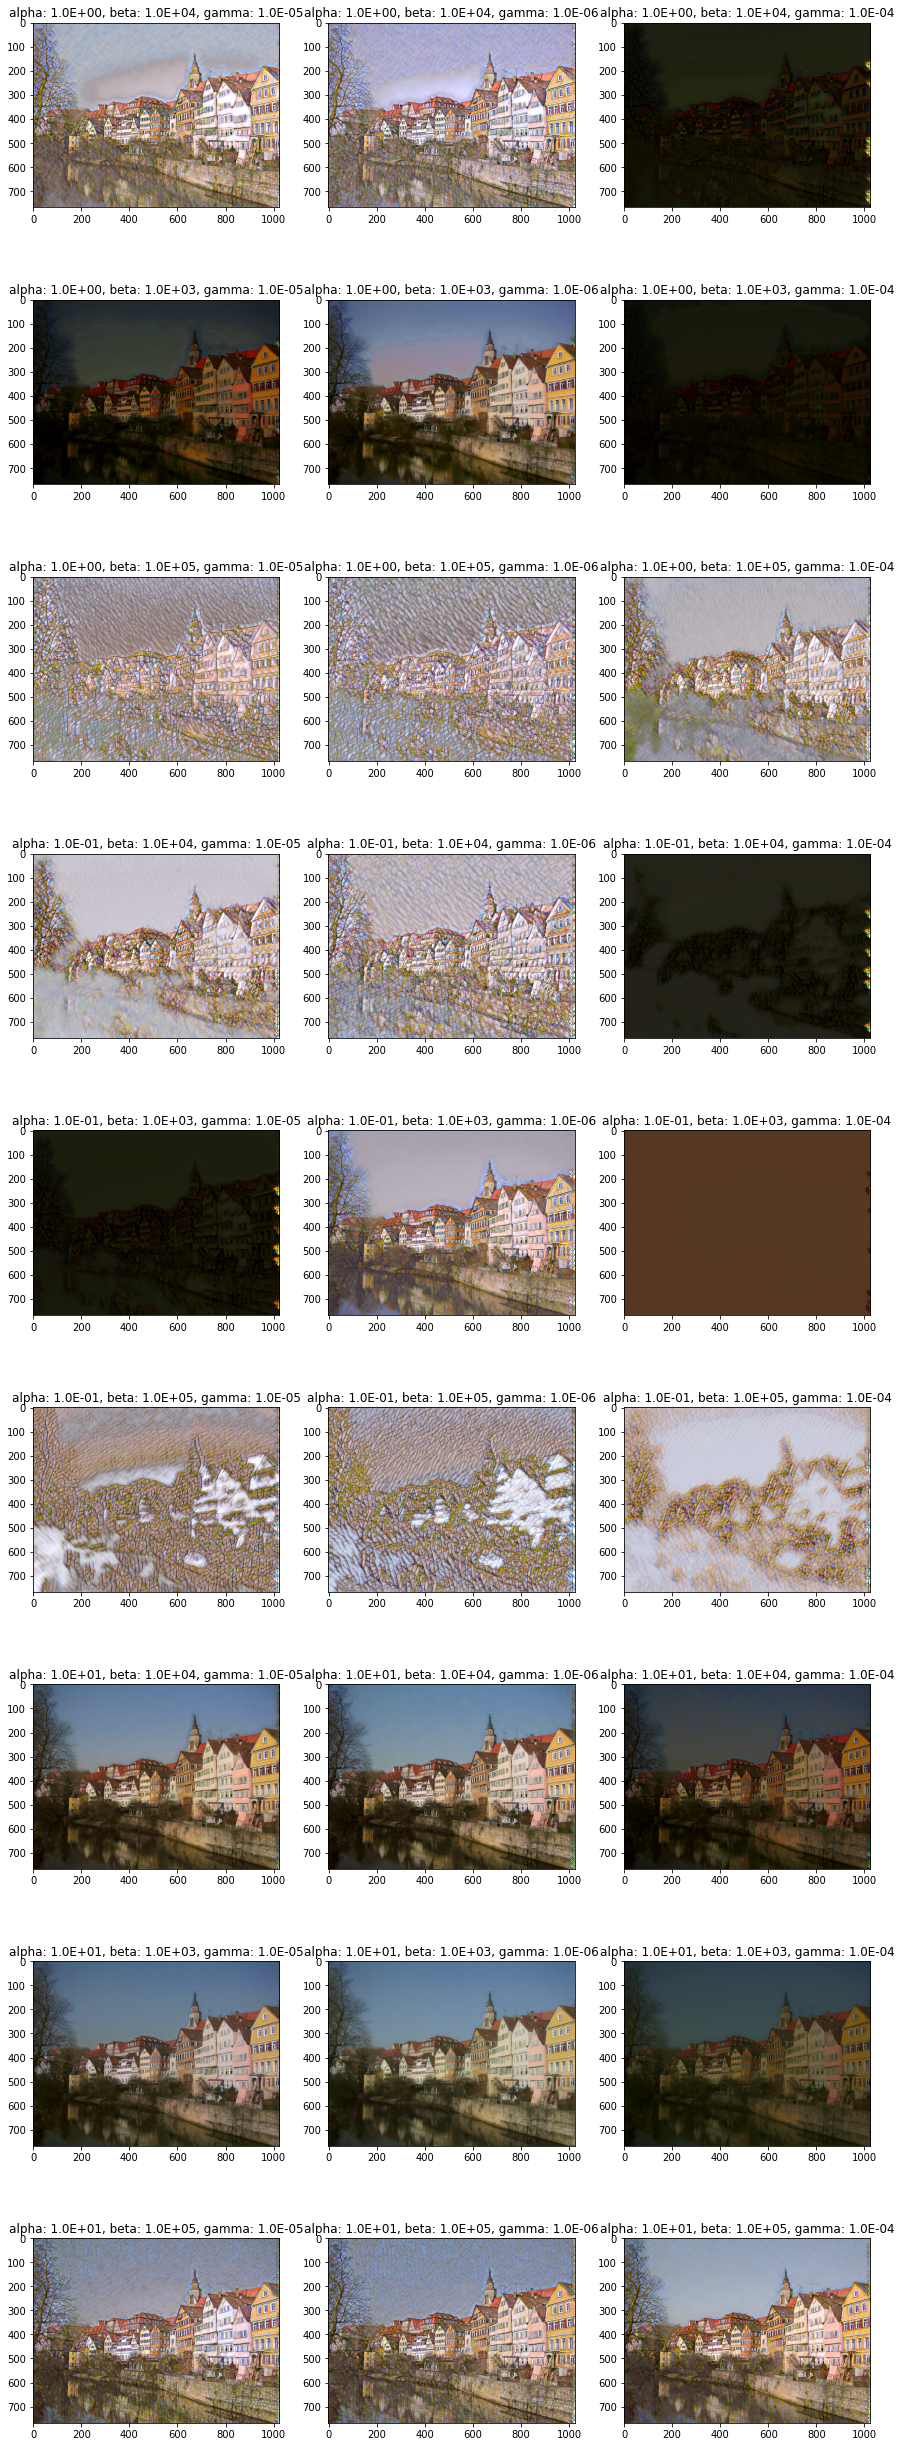

In [46]:
transformer.train()
plt.figure(figsize=(15,45))
plot_location=0
for l in range(len(alpha_list)):
    for j in range(len(beta_list)):
        for k in range(len(gamma_list)):
            plot_location+=1
            n_iter = 0
            total_running_loss = 0.0
            style_running_loss = 0.0
            content_running_loss = 0.0
            tv_running_loss = 0.0
            
            alpha=alpha_list[l]
            beta=beta_list[j]
            gamma=gamma_list[k]

            class Found(Exception): pass
            try:
                while True:
                    for x, _ in train_loader:
                        #############
                        content_running_loss = 0
                        style_running_loss = 0
                        tv_running_loss = 0

                        x = x.cuda()
                        optimizer.zero_grad()

                        #transformer 네트워크를 지난 결과
                        y_hat = transformer(x)

                        #content loss
                        content_gt = [f for f in loss_net(x, content_layer_name).values()]#x를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
                        content_layers = [f for f in loss_net(y_hat, content_layer_name).values()]#y_hat를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
                        content_running_loss = criterion(content_layers[0], content_gt[0])#둘이 차이를 criterion으로 계산


                        style_layers = [gram_matrix(f) for f in loss_net(y_hat, style_layer_name).values()]#style은 gram_matrix로 계산

                        for i in range(len(style_layer_name)):#style layer가 여러개이므로    
                            style_running_loss += criterion(style_layers[i], style_gt[i])


                        tv_running_loss = torch.sum(torch.abs(y_hat[:, :, :, :-1] - y_hat[:, :, :, 1:])) + torch.sum(torch.abs(y_hat[:, :, :-1, :] - y_hat[:, :, 1:, :]))

                        total_running_loss = alpha*content_running_loss + beta*style_running_loss + gamma*tv_running_loss
                        total_running_loss.backward()
                        optimizer.step()            
                        n_iter += 1

                        if n_iter%show_iter == (show_iter-1):
                            print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss: %.2f tv loss: %.2f'%(n_iter+1, total_running_loss.item(),
                                                                                                                         alpha*content_running_loss.item(), 
                                                                                                                         beta*style_running_loss.item(), 
                                                                                                                         gamma*tv_running_loss.item()))

                        #############

                        if n_iter >= steps:
                            raise Found

            except Found:
                print(f'alpha: {alpha:.1E}, beta: {beta:.1E}, gamma: {gamma:.1E} iterations are done')
                transformer.eval()
                result_image=inverse_transform(transformer(test_transform(content_img).cuda().unsqueeze(0)).squeeze(0))
                
                plt.subplot(len(alpha_list)*len(beta_list),len(gamma_list),plot_location)
                plt.title(f'alpha: {alpha:.1E}, beta: {beta:.1E}, gamma: {gamma:.1E}')
                plt.imshow(result_image)
plt.show()


### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

### *Discussion*

이번 실험에서는 Image Style Transfer를 구현하였다.

Neural Style with Pytorch는 코드가 이미 제공되어 있었고 내가 짜야하는 코드는 Perceptual Losses for Style Transfer with Pytorch였다. 제공되어있는 pretrained VGG는 VGG-19였고, 논문에서는 VGG-16만 사용하여서 VGG-19의 어떤 layer를 써야 하는지가 문제였다. 일단, 주어진 조건대로 style layer는 relu1-2, relu2-2, relu3-3, relu4-3을 사용했고 content layer는 relu2-2를 사용했다. 결과를 보면 마지막 iteration의 loss는 대략 13.2정도가 나왔다. 결과를 visual하게 살펴보기 위해 content image, 그에 적용된 style image, 그리고 transfer가 완료된 image를 불러왔다. style image는 mosaic style이고 trasnfer가 완료된 image를 보면 style이 적용되어 mosaic 처리가 된 모습을 볼 수 있다.

hyperparameter에 따라 변화하는 결과를 자세히 살펴보기 위하여 기본적으로 주어진 hyperparameter의 0.1배와 10배 값을 추가하여 총 3*3*3=27 개의 모델을 학습하여 이미지를 출력해보았다. 먼저 gamma값이 상대적으로 크면 결과 image가 어두워진다. 논문에 따르면 gamma값은 spatial smoothness를 encourage하는데 이 때문에 픽셀간의 명암 차이를 극단적으로 줄이기 위해 전체적으로 어두워진 것으로 보인다. 또, alpha값이 상대적으로 크면 style이 잘 변화하지 않고 content가 잘 유지되고 beta값이 상대적으로 크면 style이 더 많이 적용된다. 이러한 결과들은 논문의 이론과 일치하는 것을 확인할 수 있다. total loss를 살펴보면, loss가 상대적으로 아주 큰 경우들이 있는데, 이 경우는 hyperparameter의 값을 10배나 키웠고 iteration이 충분하지 않기 때문으로 보인다.

그리고 추가적으로 style layer로 relu1-2, relu 2-2, relu3-4, relu4-4를 사용하여 실험을 해보았다. (실험결과는 discussion 아래에 첨부하였다.) 추가적인 실험을 해본 이유는 논문에서 style layer로 relu1-2, relu2-2, relu3-3, relu4-3을 사용하는데 이는 VGG-16에서 pooling 바로 전의 layer이다. 따라서, VGG-19에서도 pooling 바로 전의 layer를 사용하는 것이 타당하다 생각해 추가적인 실험을 해보았다. 마지막 iteration의 loss는 약 12.9정도가 나왔는데 수치적으로 보면 얼마 차이가 안나는 것으로 보이지만, 앞서 한 실험과 달리 loss가 13이하인 iteration을 많이 확인할 수 있었다. visual적으로는 거의 차이가 나지 않는다.



In [19]:
'''
    vgg19_layer_names = {
    0: "conv1_1",
    1: "relu1_1",
    2: "conv1_2",
    3: "relu1_2",
    4: "pool1",
    5: "conv2_1",
    6: "relu2_1",
    7: "conv2_2",
    8: "relu2_2",
    9: "pool2",
    10: "conv3_1",
    11: "relu3_1",
    12: "conv3_2",
    13: "relu3_2",
    14: "conv3_3",
    15: "relu3_3",
    16: "conv3_4",
    17: "relu3_4",
    18: "pool3",
    19: "conv4_1",
    20: "relu4_1",
    21: "conv4_2",
    22: "relu4_2",
    23: "conv4_3",
    24: "relu4_3",
    25: "conv4_4",
    26: "relu4_4",
    27: "pool4",
    28: "conv5_1",
    29: "relu5_1",
    30: "conv5_2",
    31: "relu5_2",
    32: "conv5_3",
    33: "relu5_3",
    34: "conv5_4",
    35: "relu5_4",
    36: "pool5",
    37: "fc6",
    38: "relu6",
    39: "dropout6",
    40: "fc7",
    41: "relu7",
    42: "dropout7",
    43: "fc8"
}
'''
style_layer_name = {
   #############
    #논문의 조건은 vgg 16이지만, vgg 19를 사용한다. pooling 전 가장 마지막 relu를 사용한다. 
    '3':'relu1-2',
    '8':'relu2-2',
    '17':'relu3-4',
    '26':'relu4-4'
    #############
}

content_layer_name = {
    #############
    #그림에서는 relu3-3를 사용하라고 나와있지만, 논문의 조건은 relu2-2을 사용하라고 나와있다.
    '8':'relu2-2'
    #############
}

In [20]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

In [21]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

In [22]:
n_iter = 0
total_running_loss = 0.0
style_running_loss = 0.0
content_running_loss = 0.0
tv_running_loss = 0.0

class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            #############
            content_running_loss = 0
            style_running_loss = 0
            tv_running_loss = 0
            
            x = x.cuda()
            optimizer.zero_grad()
            
            #transformer 네트워크를 지난 결과
            y_hat = transformer(x)
            
            #content loss
            content_gt = [f for f in loss_net(x, content_layer_name).values()]#x를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
            content_layers = [f for f in loss_net(y_hat, content_layer_name).values()]#y_hat를 loss_net에 입력하여 지정한 content_layer까지 지난 출력값
            content_running_loss = criterion(content_layers[0], content_gt[0])#둘이 차이를 criterion으로 계산
            
            
            style_layers = [gram_matrix(f) for f in loss_net(y_hat, style_layer_name).values()]#style은 gram_matrix로 계산
            
            for i in range(len(style_layer_name)):#style layer가 여러개이므로    
                style_running_loss += criterion(style_layers[i], style_gt[i])
            
            
            tv_running_loss = torch.sum(torch.abs(y_hat[:, :, :, :-1] - y_hat[:, :, :, 1:])) + torch.sum(torch.abs(y_hat[:, :, :-1, :] - y_hat[:, :, 1:, :]))

            total_running_loss = alpha*content_running_loss + beta*style_running_loss + gamma*tv_running_loss
            total_running_loss.backward()
            optimizer.step()            
            n_iter += 1
            
            if n_iter%show_iter == (show_iter-1):
                print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss: %.2f tv loss: %.2f'%(n_iter+1, total_running_loss.item(),
                                                                                                             alpha*content_running_loss.item(), 
                                                                                                             beta*style_running_loss.item(), 
                                                                                                             gamma*tv_running_loss.item()))
                                                                                            
            #############
            
            if n_iter >= steps:
                raise Found

except Found:
    pass
    

Iteration: 50, total loss: 26.20, content loss: 8.52, style loss: 16.02 tv loss: 1.65
Iteration: 100, total loss: 20.81, content loss: 10.54, style loss: 7.80 tv loss: 2.47
Iteration: 150, total loss: 18.70, content loss: 9.84, style loss: 6.41 tv loss: 2.45
Iteration: 200, total loss: 17.32, content loss: 9.45, style loss: 5.17 tv loss: 2.70
Iteration: 250, total loss: 16.78, content loss: 9.20, style loss: 5.05 tv loss: 2.53
Iteration: 300, total loss: 16.10, content loss: 8.41, style loss: 5.17 tv loss: 2.52
Iteration: 350, total loss: 15.88, content loss: 8.14, style loss: 5.20 tv loss: 2.54
Iteration: 400, total loss: 15.37, content loss: 8.34, style loss: 4.55 tv loss: 2.48
Iteration: 450, total loss: 15.16, content loss: 7.79, style loss: 5.02 tv loss: 2.35
Iteration: 500, total loss: 14.42, content loss: 7.36, style loss: 4.67 tv loss: 2.38
Iteration: 550, total loss: 14.79, content loss: 8.09, style loss: 4.11 tv loss: 2.59
Iteration: 600, total loss: 14.40, content loss: 7.94

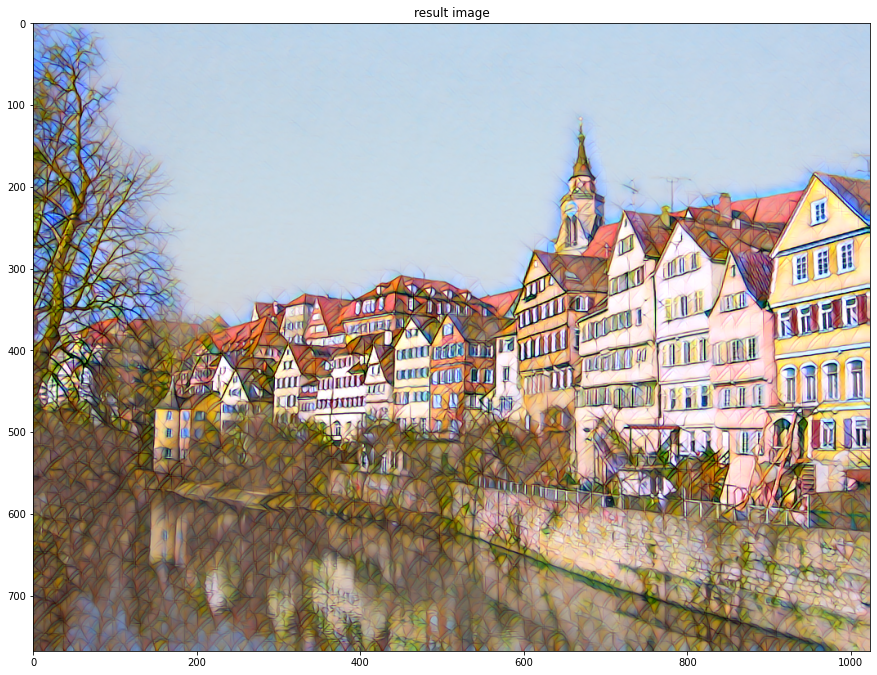

In [23]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
transformer.eval()
result_image=inverse_transform(transformer(test_transform(content_img).cuda().unsqueeze(0)).squeeze(0))

plt.figure(figsize=(15,15))
plt.title('result image')
plt.imshow(result_image)
plt.show()
#############
